# Usage of a classic dataset :20newsgroups

1. We use this standard to build a classification model on 20 high level topics
2. We use it to predict the topic of each questions. Maybe 2 or 3, certainly with a threshold
3. We add this feature to the input data: 
    * if both newsgroup tags are the same, it means they talk about the same high level subject. 
    * if they are not, it means they don't talk about the same subkect, probably questions are different



In [1]:
# Ugly incantation to make our 'framework' working
import sys
sys.path.insert(0, r'/SAPDevelop/QuoraPairs/BruteForce/Tools')

#import all our small tools (paths, cache, print,zip,excel, pandas, progress,..)
from Tools.all import *

# setup the name of our experiment
# it will be used to store every result in a unique place
EXPERIMENT='newsgroups'
# Do a bit of checks before actually running code
UNITARY_TEST = True
print_alert('You will use environment %s' % EXPERIMENT)

prepare_environnement(EXPERIMENT)
train_dataframe=load_dataframe(CLEAN_TRAINING_DATA)
challenge_dataframe=load_dataframe(CLEAN_CHALLENGE_DATA)
print_section('Untouched input data has been loaded. Training: %d lines Challenge: %d lines' % (len(train_dataframe),len(challenge_dataframe)))


In [2]:
from sklearn.datasets import fetch_20newsgroups
twenty_train = fetch_20newsgroups(subset='train', shuffle=True, remove=('headers','footers','quotes'),random_state=42)
twenty_test =  fetch_20newsgroups(subset='test' , shuffle=True, remove=('headers','footers','quotes'),random_state=42)

Here are the labels

In [3]:
twenty_train.target_names

['alt.atheism',
 'comp.graphics',
 'comp.os.ms-windows.misc',
 'comp.sys.ibm.pc.hardware',
 'comp.sys.mac.hardware',
 'comp.windows.x',
 'misc.forsale',
 'rec.autos',
 'rec.motorcycles',
 'rec.sport.baseball',
 'rec.sport.hockey',
 'sci.crypt',
 'sci.electronics',
 'sci.med',
 'sci.space',
 'soc.religion.christian',
 'talk.politics.guns',
 'talk.politics.mideast',
 'talk.politics.misc',
 'talk.religion.misc']

A bit of cleaning

In [4]:
import re

train_news = pandas.DataFrame(twenty_train.data,columns=['text'])
train_news['text'] = train_news['text'].apply(lambda t: re.sub('[\n]+',' ',t))
train_news['target'] = twenty_train.target

test_news = pandas.DataFrame(twenty_test.data,columns=['text'])
test_news['text'] = test_news['text'].apply(lambda t: re.sub('[\n]+',' ',t))
test_news['target'] = twenty_test.target


We merge some newsgroups to make them a little bit more generic

In [5]:
MAPPING = {
0:0, #'alt.atheism' -> religion
1:1, #'comp.graphics' -> computers
2:1, #'comp.os.ms-windows.misc' -> computers
3:1, #'comp.sys.ibm.pc.hardware' -> computers
4:1, #'comp.sys.mac.hardware' -> computers
5:1, #'comp.windows.x' -> computers
6:2, #'misc.forsale', -> forsale
7:3, #'rec.autos' -> vehicle
8:3, #'rec.motorcycles', -> vehicle
9:4, #'rec.sport.baseball' -> sport
10:4, #'rec.sport.hockey', -> sport
11:5, #'sci.crypt', -> science
12:5, #'sci.electronics', -> science
13:5, #'sci.med', -> science
14:5, #'sci.space', -> science
15:0, #'soc.religion.christian', ->religion
16:6, # talk.politics.guns',->politics
17:6, #'talk.politics.mideast',->politics
18:6, #'talk.politics.misc',->politics
19:0, #'talk.religion.misc'-> religion
}

NEW_LABELS=[
    'religion', #0
    'computers', #1
    'forsale', #2
    'vehicles', #3
    'sport', #4
    'science', #5
    'politics', #6
]


In [6]:
train_news['new_target']=train_news['target'].apply(lambda k: MAPPING[k])
test_news['new_target']=test_news['target'].apply(lambda k: MAPPING[k])


Define a simple pipeline:
* Count all words
* Generate TfIdf
* build a Multinomial Naive Bayes model

In [7]:
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
text_clf = Pipeline([('vect', CountVectorizer(ngram_range=(1,2))), ('tfidf', TfidfTransformer(use_idf=True)), ('clf', MultinomialNB(alpha=0.01))])

text_clf = text_clf.fit(train_news['text'], train_news['new_target'])

              precision    recall  f1-score   support

    religion       0.79      0.82      0.80       968
   computers       0.76      0.92      0.83      1955
     forsale       0.95      0.54      0.69       390
    vehicles       0.93      0.68      0.78       794
       sport       0.97      0.84      0.90       796
     science       0.76      0.77      0.76      1579
    politics       0.77      0.80      0.79      1050

    accuracy                           0.80      7532
   macro avg       0.85      0.76      0.79      7532
weighted avg       0.81      0.80      0.80      7532



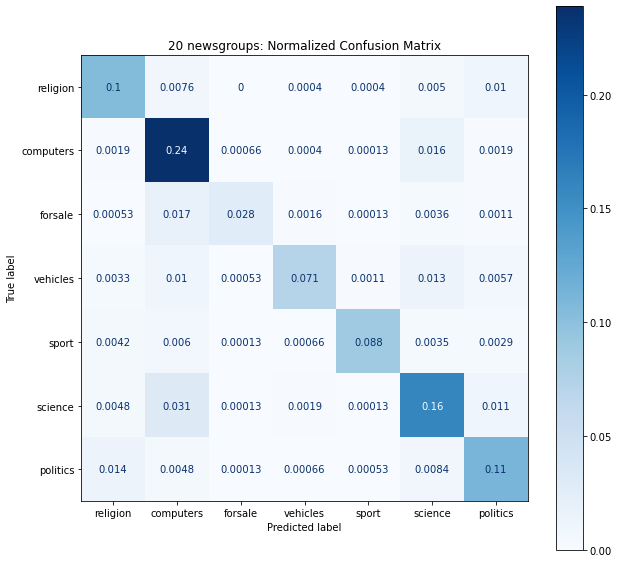

In [8]:
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import classification_report


predicted = text_clf.predict(test_news['text'])
#print(numpy.mean(predicted == test_news['new_target']))
print_info('Performances')
print(classification_report(test_news['new_target'],predicted,target_names=NEW_LABELS))

# display a cool graph
fig, ax = plot.subplots(figsize=(10, 10))
plot_confusion_matrix(text_clf,test_news['text'],test_news['new_target'],cmap=plot.cm.Blues,normalize='all',display_labels=NEW_LABELS,ax=ax)
ax.set_title('20 newsgroups: Normalized Confusion Matrix')
plot_save('newsgroup_confusion_matrix')


Now, apply this model to our datasets

In [9]:
train_newsgroup_proba_question1 = pandas.DataFrame(data=text_clf.predict_proba(train_dataframe['question1']),columns=['proba_'+k+'_question1' for k in NEW_LABELS])
train_newsgroup_proba_question2 = pandas.DataFrame(data=text_clf.predict_proba(train_dataframe['question2']),columns=['proba_'+k+'_question2' for k in NEW_LABELS])

# Glue the 2 proba dataset
train_newsgroup_proba = pandas.concat([train_newsgroup_proba_question1,train_newsgroup_proba_question2.set_index(train_newsgroup_proba_question1.index)],axis=1)
# save it in global repo
save_global_dataframe(train_newsgroup_proba,'train_newsgroup_proba')
del train_newsgroup_proba_question1
del train_newsgroup_proba_question2


In [10]:
challenge_newsgroup_proba_question1 = pandas.DataFrame(data=text_clf.predict_proba(challenge_dataframe['question1']),columns=['proba_'+k+'_question1' for k in NEW_LABELS])
challenge_newsgroup_proba_question2 = pandas.DataFrame(data=text_clf.predict_proba(challenge_dataframe['question2']),columns=['proba_'+k+'_question2' for k in NEW_LABELS])

# Glue the 2 proba dataset
challenge_newsgroup_proba = pandas.concat([challenge_newsgroup_proba_question1,challenge_newsgroup_proba_question2.set_index(challenge_newsgroup_proba_question1.index)],axis=1)
# save it in global repo
save_global_dataframe(challenge_newsgroup_proba,'challenge_newsgroup_proba')
del challenge_newsgroup_proba_question1
del challenge_newsgroup_proba_question2


In [15]:
essai = pandas.DataFrame(text_clf.predict_proba(train_dataframe['question1']))


In [16]:
essai

,0,1,2,3,4,5,6
0,0.069818,0.618484,0.002983,0.075150,0.001285,0.197528,0.034751
1,0.382280,0.357707,0.003411,0.017413,0.053893,0.085166,0.100129
2,0.004480,0.618663,0.000317,0.020180,0.000563,0.350420,0.005378
3,0.134396,0.263743,0.001790,0.012134,0.005152,0.221771,0.361015
4,0.006511,0.000891,0.003931,0.036289,0.001772,0.943981,0.006624
...,...,...,...,...,...,...,...
404285,0.015788,0.621324,0.002383,0.010360,0.006396,0.314321,0.029427
404286,0.948572,0.008435,0.000903,0.010329,0.003559,0.014964,0.013238
404287,0.220572,0.097670,0.003229,0.148798,0.122903,0.288373,0.118456
404288,0.032978,0.046056,0.017844,0.165816,0.033001,0.285931,0.418374
